# Introduction to Physical Architecture API

**Note**: In this notebook we will use `pandas` dataframes library to construct and visualize tables, **if you don't have pandas installed** in the current environemnt you may want to do so by running the cell below.

In [12]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


The cell below loads our test model so we could play with it and silences warnings.

In [13]:
import capellambse
import logging
import pandas as pd


logging.getLogger().setLevel(logging.CRITICAL)
model = capellambse.MelodyModel(
    "../tests/data/melodymodel/5_0/Melody Model Test.aird",
    jupyter_untrusted=True,
)

but before we jump into code, lets have a look first at Capella metamodel concerning the Physical Architecture layer (PA).

Things in PA are very similar to what we see in SysML when it comes to `ibd`s (Internal Block Diagrams) - the boxes we see on those are `Part`s that are instanciated from `Block` objects. Same happens in Capella - the boxes we see on `PAB` diagrams are `Parts` that were instanciated from `PhysicalComponent`s. Here also comes the very special difference of Capella - unless you explicitly enable **part re-use**, `PhysicalComponent` will always have only one `Part`. This is the default behavior of Capella. 

Our API should support both cases but at the moment we don't use models with **part re-use** enabled in production yet and so don't test the library against this case. Yet we do implement Parts and support many parts - one component relationship model.

One more issue to mention - rendering PA diagrams outside of Capella was never a high priority so the resulting representations of PABs rendered without Capella are not very accurate at the moment. We hope to improve it soon though. If you still do want to see how it looks like when we render it right now - uncomment the `# diagram` in the cell below

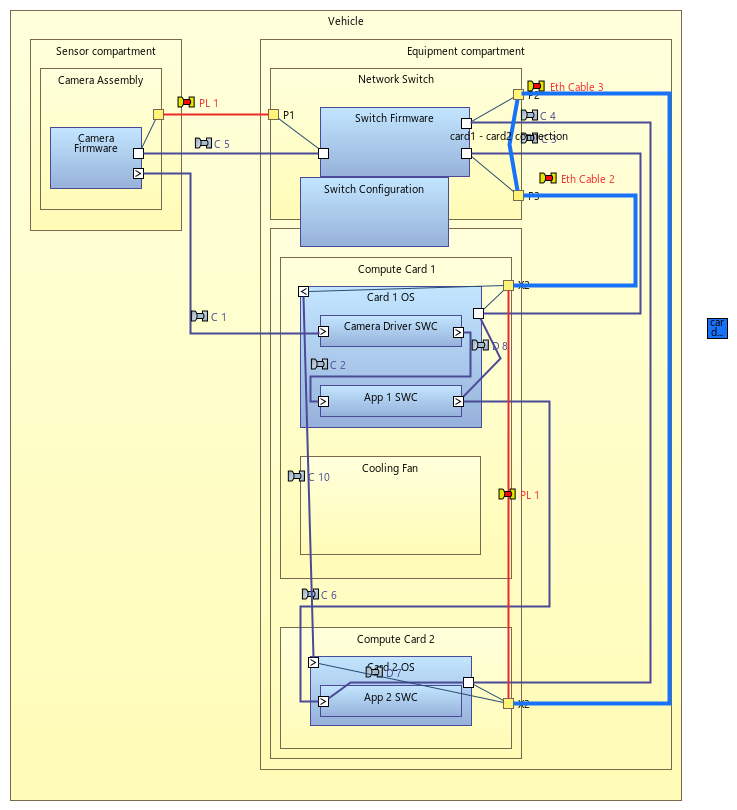

In [14]:
diagram = model.pa.diagrams.by_name("[PAB] A sample vehicle arch")
diagram

# Example 1: List components that are visible on a diagram

To start, lets get all parts on that diagram and turn them into PhysicalComponents

In [15]:
components_on_diagram = list(map(lambda x: x.type, diagram.nodes.by_type("Part")))
components_on_diagram

[<PhysicalComponent 'Switch Configuration' (23c47b69-7352-481d-be88-498fb351adbe)>,
 <PhysicalComponent 'Card 2 OS' (09e19313-c824-467f-9fb5-95ed8b4e2d51)>,
 <PhysicalComponent 'Camera Driver SWC' (74067f56-33bf-47f5-bb8b-f3604097f653)>,
 <PhysicalComponent 'Camera Firmware' (db2d86d7-48ee-478b-a6fc-d6387ab0032e)>,
 <PhysicalComponent 'Vehicle' (b327d900-abd2-4138-a111-9ff0684739d8)>,
 <PhysicalComponent 'Network Switch' (b51ccc6f-5f96-4e28-b90e-72463a3b50cf)>,
 <PhysicalComponent 'Card 1 OS' (7b188ad0-0d82-4b2c-9913-45292e537871)>,
 <PhysicalComponent 'Camera Assembly' (5bfc516b-c20d-4007-9a38-5ba0e889d0a4)>,
 <PhysicalComponent 'Sensor compartment' (3f416925-9d8a-4e9c-99f3-e912efb23d2f)>,
 <PhysicalComponent 'Equipment compartment' (3d68852d-fcc0-452c-af12-a2fbe22f81fa)>,
 <PhysicalComponent 'App 1 SWC' (b80a6fcc-8d35-4675-a2e6-60efcbd61e27)>,
 <PhysicalComponent 'Compute Card 1' (63be604e-883e-41ea-9023-fc74f29906fe)>,
 <PhysicalComponent 'Server' (9137f463-7497-40c2-b20a-897158fdba

we could also get all components across PA layer by doing `model.pa.all_components` but we will not go there in this example.

We can review any single component from that list above

In [16]:
components_on_diagram[7]

components,"PhysicalComponent ""Camera Firmware"" (db2d86d7-48ee-478b-a6fc-d6387ab0032e)"
constraints,(Empty list)
deployed_components,"PhysicalComponent ""Camera Firmware"" (db2d86d7-48ee-478b-a6fc-d6387ab0032e)"
deploying_components,(Empty list)
description,None
diagrams,(Empty list)
exchanges,(Empty list)
functions,(Empty list)
is_abstract,False
is_actor,False
is_human,False


However we may need just a few of those attributes in a view.

Now that we have a list of components lets collect some of the attributes of interest in a table. To keep it simple we'll introduce an attribute extractor function that will turn fields of interset into a nice dictionary.

In [17]:
def extract_attrs_of_interest(component):
    return dict(
        name=component.name,
        nature=component.nature,
        kind=component.kind,
        components="; ".join([cmp.name for cmp in component.components])
    )

we can then apply that extractor function to our list of components and use `pandas` to display it for us in a tabular form

In [18]:
pd.DataFrame(list(map(extract_attrs_of_interest, components_on_diagram)))

,name,nature,kind,components
0,Switch Configuration,BEHAVIOR,DATA,
1,Card 2 OS,BEHAVIOR,SOFTWARE,App 2 SWC
2,Camera Driver SWC,BEHAVIOR,SOFTWARE,
3,Camera Firmware,BEHAVIOR,SOFTWARE_EXECUTION_UNIT,
4,Vehicle,NODE,SOFTWARE_DEPLOYMENT_UNIT,Equipment compartment; Sensor compartment
5,Network Switch,NODE,HARDWARE,Switch Firmware; Switch Configuration
6,Card 1 OS,BEHAVIOR,SERVICES,Camera Driver SWC; App 1 SWC
7,Camera Assembly,NODE,HARDWARE,Camera Firmware
8,Sensor compartment,NODE,FACILITIES,Camera Assembly
9,Equipment compartment,NODE,FACILITIES,Server; Network Switch


# Example 2: Create HW-SW allocation table

Now lets assume that components of node nature are hardware things and behavior corresponds to software components. Assuming that lets identify leaf hardware components (lowest replaceable units) and for each of those indicate which software components they have.

To get there lets first filter out the list of components of Node nature that have at least on subcomponent of Behavior nature. To get to the end result quicker we'll use the `._filter` method of our object list. To use that method we'll need to provide a function that selects attribute of interest and a value (or list of values) that this attribute should have to be selected. To shorten the expression we'll use `lambda` functions - a way to define new function in place.

In [19]:
def select_nature(component):
    return component.nature


cmps = model.pa.all_components[1:]._filter(select_nature, "NODE")
# Note: the above [1:] assumes that 0th component is the root component and is not of interest (+ see issue #41)
cmps_with_sw = cmps._filter(lambda x: any(x.components._filter(select_nature, "BEHAVIOR")), True)
cmps_with_sw

<ElementList at 0x00007F0728631210 [<PhysicalComponent 'Sub PC' (793e6da2-d019-4716-a5c5-af8ad550ca5e)>, <PhysicalComponent 'Deploy Sub PC' (8a6c6ec9-095d-4d8b-9728-69bc79af5f27)>, <PhysicalComponent 'Compute Card 1' (63be604e-883e-41ea-9023-fc74f29906fe)>, <PhysicalComponent 'Compute Card 2' (3a982128-3281-4d37-8838-a6058b7a25d9)>, <PhysicalComponent 'Network Switch' (b51ccc6f-5f96-4e28-b90e-72463a3b50cf)>, <PhysicalComponent 'Camera Assembly' (5bfc516b-c20d-4007-9a38-5ba0e889d0a4)>]>

For sure we could come to the above list filtering by `kind` attribute, however in practice not all projects strictly use the `kind` attribute / it needs manual setting and maintenance and therefore is a bit less reliable.

Our next stop is to list the SW components of those HW components. As SW components may be nested (i.e. apps on OS or partitions, etc.) we would simply "flatten" that hierarchy. We can create function `get_sw_components` that would recursively crawl down the SW components tree and give us back a flat list and test it on one component.

In [20]:
def get_sw_components(sw_component):
    subcmp = sw_component.components._filter(select_nature, "BEHAVIOR")
    for cmp in subcmp:
        subcmp += get_sw_components(cmp)
    return subcmp

get_sw_components(cmps_with_sw[0])

<ElementList at 0x00007F0754EE80E0 [<PhysicalComponent 'PC 16' (8bc4b7a6-1f90-4f5f-a6b4-08fd300fc927)>]>

lets apply `get_sw_components` function to the complete list of components with SW, `cmps_with_sw` and turn the results into a table. In this table we'll serialize SW components into a ;-separated string:

In [21]:
def describe_hw_component_sw_allocations(hw_component):
    return dict(
        hardware_component=hw_component.name,
        deployed_sw_components="; ".join(map(lambda x: x.name, get_sw_components(hw_component)))
    )

df = pd.DataFrame(list(map(describe_hw_component_sw_allocations, cmps_with_sw)))
df

,hardware_component,deployed_sw_components
0,Sub PC,PC 16
1,Deploy Sub PC,PC 17
2,Compute Card 1,Card 1 OS; Camera Driver SWC; App 1 SWC
3,Compute Card 2,Card 2 OS; App 2 SWC
4,Network Switch,Switch Firmware; Switch Configuration
5,Camera Assembly,Camera Firmware


to complete the picture we could also list all HW components that dont have software (so that a sanity check could be perofrmed)

In [22]:
cmps_without_sw = cmps._filter(lambda x: any(x.components._filter(select_nature, "BEHAVIOR")), False)
cmps_without_sw

<ElementList at 0x00007F0754EE8FE0 [<PhysicalComponent 'PC 1' (8a6d68c8-ac3d-4654-a07e-ada7adeed09f)>, <PhysicalComponent 'PC 3' (f5d7980d-e1e9-4515-8bb0-be7e80ac5839)>, <PhysicalComponent 'Vehicle' (a2c7f619-b38a-4b92-94a5-cbaa631badfc)>, <PhysicalComponent 'Vehicle' (b327d900-abd2-4138-a111-9ff0684739d8)>, <PhysicalComponent 'Equipment compartment' (3d68852d-fcc0-452c-af12-a2fbe22f81fa)>, <PhysicalComponent 'Server' (9137f463-7497-40c2-b20a-897158fdba9a)>, <PhysicalComponent 'Cooling Fan' (65e82f3f-c5b7-44c1-bfea-8e20bb0230be)>, <PhysicalComponent 'Sensor compartment' (3f416925-9d8a-4e9c-99f3-e912efb23d2f)>, <PhysicalComponent 'PA 1' (a0847e9c-8b82-407d-8143-e908e2db97a1)>]>